In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.models import clone_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data  = np.load("/kaggle/input/de-lds-shuffled-seed/shuffled_data1.npy")
labels_edited  = np.load("/kaggle/input/de-lds-shuffled-seed/shuffled_labels1.npy")

In [3]:
max = np.max(data)
min = np.min(data)

#Normalizing data
data = data/max
data = (data - np.mean(data))/np.std(data)


#Splitting Dataset into train, validation, test 
train_labels = labels_edited[0:550]
test_labels = labels_edited[550:600]
final_labels = labels_edited[600:675]

train_data = data[0:550]
test_data = data[550:600]
final_test = data[600:675]



cf_labels = np.where(final_labels== -1, 2, final_labels) #Label in the form for confusion matrix
un, co = np.unique(cf_labels, return_counts=True)
print(f'Unique: {un}, Counts: {co}')

Unique: [0. 1. 2.], Counts: [24 26 25]


In [4]:
train_labels_reshaped = train_labels.reshape(-1,1) #Formatting for input to the CNN model
test_labels_reshaped = test_labels.reshape(-1,1)
final_labels_reshaped = final_labels.reshape(-1,1)

train_labels_reshaped = to_categorical(train_labels_reshaped, 3) #One Hot Encoding
test_labels_reshaped = to_categorical(test_labels_reshaped, 3)
final_labels_reshaped = to_categorical(final_labels_reshaped, 3)

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras
import numpy as np
import time

# Assuming you have your data, labels, train_data, test_data, train_labels_reshaped, test_labels_reshaped defined earlier

# Define 10-fold cross-validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=4)

cvscores = []
best_accuracy = 0.0
best_model = None
best_model_history = None

# Record the start time
start_time = time.time()

for fold_num, (train, test) in enumerate(kfold.split(data, labels_edited)):
    # CNN Model
    model = Sequential([
        Conv2D(filters=64, kernel_size=5, input_shape=(62, 265, 5), padding='same'),
        Conv2D(filters=64, kernel_size=3, padding='same'),
        Conv2D(filters=64, kernel_size=3, padding='same'),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(rate=0.3),
        Conv2D(filters=128, kernel_size=3, padding='same'),
        Conv2D(filters=128, kernel_size=3, padding='same'),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(rate=0.2),
        Conv2D(filters=256, kernel_size=3, padding='same'),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(rate=0.25),
        Conv2D(filters=512, kernel_size=3, padding='same'),
        MaxPooling2D(pool_size=2, strides=2),
        Dropout(rate=0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(rate=0.4),
        Dense(256, activation='relu'),
        Dropout(rate=0.2),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Compile CNN Model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=9e-5),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

    # Fit the CNN model
    reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5)

    history = model.fit(
        train_data,
        train_labels_reshaped,
        batch_size=64,
        epochs=100,
        validation_data=(test_data, test_labels_reshaped),
        callbacks=[reduce_lr_cnn]
    )

    # Evaluate the model on the test set
    scores = model.evaluate(test_data, test_labels_reshaped, verbose=0)

    print(f"Accuracy for fold {fold_num + 1}: {scores[1]*100:.2f}%")

    # Append the accuracy for this fold to the list
    cvscores.append(scores[1] * 100)

    # Update the best model if the current fold has a higher accuracy
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        # Use clone_model to create a new instance of the best model without reusing weights
        best_model = keras.models.clone_model(model)
        best_model.set_weights(model.get_weights())
        best_model_history = history.history
        

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Print the average and standard deviation of accuracy across all folds
print(f"Average Accuracy: {np.mean(cvscores):.2f}% (+/- {np.std(cvscores):.2f}%)")


Epoch 1/100


2024-01-13 19:55:19.112336: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 13s 555ms/step - loss: 1.1300 - accuracy: 0.3873 - root_mean_squared_error: 0.4773 - val_loss: 1.0089 - val_accuracy: 0.5200 - val_root_mean_squared_error: 0.4499 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 162ms/step - loss: 1.0393 - accuracy: 0.4527 - root_mean_squared_error: 0.4571 - val_loss: 0.9965 - val_accuracy: 0.5200 - val_root_mean_squared_error: 0.4473 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 161ms/step - loss: 0.9824 - accuracy: 0.5000 - root_mean_squared_error: 0.4434 - val_loss: 0.8653 - val_accuracy: 0.6000 - val_root_mean_squared_error: 0.4117 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 162ms/step - loss: 0.9214 - accuracy: 0.5600 - root_mean_squared_error: 0.4272 - val_loss: 0.8010 - val_accuracy: 0.6800 - val_root_mean_squared_error: 0.3948 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 160ms/step - loss: 0.7609 - accuracy:

2024-01-13 19:57:57.782726: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 5s 192ms/step - loss: 1.1635 - accuracy: 0.3564 - root_mean_squared_error: 0.4842 - val_loss: 1.0317 - val_accuracy: 0.5400 - val_root_mean_squared_error: 0.4551 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 160ms/step - loss: 1.0613 - accuracy: 0.4455 - root_mean_squared_error: 0.4623 - val_loss: 0.9798 - val_accuracy: 0.5000 - val_root_mean_squared_error: 0.4424 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 159ms/step - loss: 0.9605 - accuracy: 0.5000 - root_mean_squared_error: 0.4367 - val_loss: 0.8870 - val_accuracy: 0.5200 - val_root_mean_squared_error: 0.4179 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 159ms/step - loss: 0.8779 - accuracy: 0.5564 - root_mean_squared_error: 0.4192 - val_loss: 0.8472 - val_accuracy: 0.5800 - val_root_mean_squared_error: 0.4085 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 159ms/step - loss: 0.7704 - accuracy: 

2024-01-13 20:00:26.459858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 5s 193ms/step - loss: 1.1959 - accuracy: 0.3309 - root_mean_squared_error: 0.4918 - val_loss: 1.0811 - val_accuracy: 0.3600 - val_root_mean_squared_error: 0.4671 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 160ms/step - loss: 1.0851 - accuracy: 0.4036 - root_mean_squared_error: 0.4678 - val_loss: 1.0170 - val_accuracy: 0.5400 - val_root_mean_squared_error: 0.4516 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 160ms/step - loss: 1.0042 - accuracy: 0.5073 - root_mean_squared_error: 0.4473 - val_loss: 0.9143 - val_accuracy: 0.5400 - val_root_mean_squared_error: 0.4239 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 159ms/step - loss: 0.9054 - accuracy: 0.5527 - root_mean_squared_error: 0.4242 - val_loss: 0.7713 - val_accuracy: 0.7200 - val_root_mean_squared_error: 0.3861 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 159ms/step - loss: 0.7553 - accuracy: 

2024-01-13 20:02:56.005991: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 6s 192ms/step - loss: 1.1131 - accuracy: 0.4036 - root_mean_squared_error: 0.4741 - val_loss: 1.0043 - val_accuracy: 0.5600 - val_root_mean_squared_error: 0.4475 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 160ms/step - loss: 1.0208 - accuracy: 0.4709 - root_mean_squared_error: 0.4514 - val_loss: 0.8924 - val_accuracy: 0.6600 - val_root_mean_squared_error: 0.4174 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 160ms/step - loss: 0.8942 - accuracy: 0.5800 - root_mean_squared_error: 0.4205 - val_loss: 0.7412 - val_accuracy: 0.7600 - val_root_mean_squared_error: 0.3764 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 158ms/step - loss: 0.7630 - accuracy: 0.6382 - root_mean_squared_error: 0.3889 - val_loss: 0.6616 - val_accuracy: 0.7400 - val_root_mean_squared_error: 0.3609 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 162ms/step - loss: 0.7162 - accuracy: 

2024-01-13 20:05:24.828227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 5s 193ms/step - loss: 1.1473 - accuracy: 0.3745 - root_mean_squared_error: 0.4801 - val_loss: 1.0389 - val_accuracy: 0.4800 - val_root_mean_squared_error: 0.4569 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 159ms/step - loss: 1.0482 - accuracy: 0.4673 - root_mean_squared_error: 0.4566 - val_loss: 0.9247 - val_accuracy: 0.7200 - val_root_mean_squared_error: 0.4279 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 160ms/step - loss: 0.9456 - accuracy: 0.5218 - root_mean_squared_error: 0.4347 - val_loss: 0.8198 - val_accuracy: 0.7800 - val_root_mean_squared_error: 0.4002 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 160ms/step - loss: 0.8558 - accuracy: 0.5909 - root_mean_squared_error: 0.4130 - val_loss: 0.6781 - val_accuracy: 0.7200 - val_root_mean_squared_error: 0.3607 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 158ms/step - loss: 0.7851 - accuracy: 

2024-01-13 20:07:53.463111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 5s 193ms/step - loss: 1.1307 - accuracy: 0.3509 - root_mean_squared_error: 0.4776 - val_loss: 1.0367 - val_accuracy: 0.5000 - val_root_mean_squared_error: 0.4567 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 160ms/step - loss: 1.0842 - accuracy: 0.4236 - root_mean_squared_error: 0.4673 - val_loss: 0.9980 - val_accuracy: 0.7200 - val_root_mean_squared_error: 0.4465 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 159ms/step - loss: 1.0024 - accuracy: 0.5200 - root_mean_squared_error: 0.4468 - val_loss: 0.9083 - val_accuracy: 0.6000 - val_root_mean_squared_error: 0.4220 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 159ms/step - loss: 0.8697 - accuracy: 0.5909 - root_mean_squared_error: 0.4145 - val_loss: 0.7181 - val_accuracy: 0.7000 - val_root_mean_squared_error: 0.3699 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 160ms/step - loss: 0.7311 - accuracy: 

2024-01-13 20:10:21.955424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 5s 191ms/step - loss: 1.1781 - accuracy: 0.3473 - root_mean_squared_error: 0.4866 - val_loss: 1.0580 - val_accuracy: 0.5000 - val_root_mean_squared_error: 0.4617 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 161ms/step - loss: 1.0592 - accuracy: 0.4473 - root_mean_squared_error: 0.4616 - val_loss: 0.9994 - val_accuracy: 0.5200 - val_root_mean_squared_error: 0.4477 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 161ms/step - loss: 1.0174 - accuracy: 0.4782 - root_mean_squared_error: 0.4515 - val_loss: 0.8783 - val_accuracy: 0.6800 - val_root_mean_squared_error: 0.4153 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 160ms/step - loss: 0.8776 - accuracy: 0.5891 - root_mean_squared_error: 0.4173 - val_loss: 0.6987 - val_accuracy: 0.8200 - val_root_mean_squared_error: 0.3623 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 161ms/step - loss: 0.7746 - accuracy: 

2024-01-13 20:12:50.807962: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 5s 190ms/step - loss: 1.1526 - accuracy: 0.3891 - root_mean_squared_error: 0.4827 - val_loss: 1.0300 - val_accuracy: 0.5600 - val_root_mean_squared_error: 0.4544 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 160ms/step - loss: 1.0712 - accuracy: 0.4327 - root_mean_squared_error: 0.4645 - val_loss: 1.0167 - val_accuracy: 0.5200 - val_root_mean_squared_error: 0.4518 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 160ms/step - loss: 1.0224 - accuracy: 0.4818 - root_mean_squared_error: 0.4520 - val_loss: 0.9211 - val_accuracy: 0.5400 - val_root_mean_squared_error: 0.4270 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 160ms/step - loss: 0.9234 - accuracy: 0.5473 - root_mean_squared_error: 0.4289 - val_loss: 0.7973 - val_accuracy: 0.6400 - val_root_mean_squared_error: 0.3934 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 163ms/step - loss: 0.7919 - accuracy: 

2024-01-13 20:15:19.669012: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 5s 192ms/step - loss: 1.1118 - accuracy: 0.4000 - root_mean_squared_error: 0.4740 - val_loss: 1.0108 - val_accuracy: 0.6000 - val_root_mean_squared_error: 0.4494 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 160ms/step - loss: 1.0496 - accuracy: 0.4345 - root_mean_squared_error: 0.4599 - val_loss: 0.9486 - val_accuracy: 0.5000 - val_root_mean_squared_error: 0.4344 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 159ms/step - loss: 0.9493 - accuracy: 0.5200 - root_mean_squared_error: 0.4333 - val_loss: 0.7580 - val_accuracy: 0.7600 - val_root_mean_squared_error: 0.3834 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 160ms/step - loss: 0.8074 - accuracy: 0.5873 - root_mean_squared_error: 0.4012 - val_loss: 0.7067 - val_accuracy: 0.7600 - val_root_mean_squared_error: 0.3714 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 160ms/step - loss: 0.7044 - accuracy: 

2024-01-13 20:17:49.163289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 5s 192ms/step - loss: 1.0953 - accuracy: 0.3800 - root_mean_squared_error: 0.4689 - val_loss: 0.9847 - val_accuracy: 0.5800 - val_root_mean_squared_error: 0.4439 - lr: 9.0000e-05
Epoch 2/100
9/9 [==============================] - 1s 159ms/step - loss: 1.0347 - accuracy: 0.4655 - root_mean_squared_error: 0.4546 - val_loss: 0.9176 - val_accuracy: 0.7200 - val_root_mean_squared_error: 0.4254 - lr: 9.0000e-05
Epoch 3/100
9/9 [==============================] - 1s 159ms/step - loss: 0.9512 - accuracy: 0.5527 - root_mean_squared_error: 0.4351 - val_loss: 0.8359 - val_accuracy: 0.6200 - val_root_mean_squared_error: 0.4046 - lr: 9.0000e-05
Epoch 4/100
9/9 [==============================] - 1s 160ms/step - loss: 0.8871 - accuracy: 0.5764 - root_mean_squared_error: 0.4193 - val_loss: 0.7860 - val_accuracy: 0.6000 - val_root_mean_squared_error: 0.3922 - lr: 9.0000e-05
Epoch 5/100
9/9 [==============================] - 1s 159ms/step - loss: 0.7540 - accuracy: 

In [6]:
model = best_model
history = best_model_history

model.compile(optimizer=keras.optimizers.Adam(learning_rate=9e-5),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

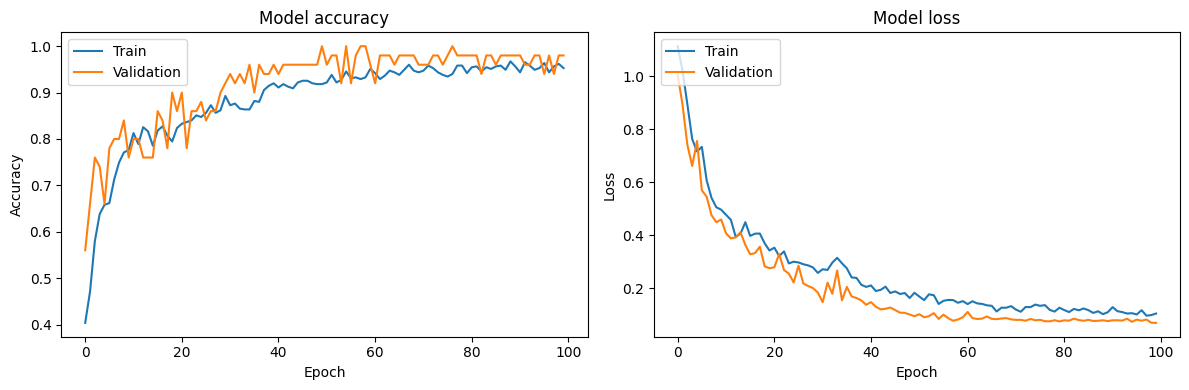

In [7]:
plt.figure(figsize=(12, 4))
dpi = 300

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

plt.savefig("Loss_Accuracy_curve_try2_1.png", dpi=dpi)
plt.show()

In [8]:
# Evaluate the model on the final test set
scores = model.evaluate(final_test, final_labels_reshaped, verbose=1)
print(f"Final Test Loss: {scores[0]}")
print(f"Final Test Accuracy: {scores[1]}")

# Get predictions for the final test set
y_pred = model.predict(final_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(final_labels_reshaped, axis=1)

# Print classification report
print("Classification Report:try2_1")
print(classification_report(y_true, y_pred_classes))

3/3 [==============================] - 1s 187ms/step - loss: 0.1766 - accuracy: 0.9067 - root_mean_squared_error: 0.2031
Final Test Loss: 0.17662228643894196
Final Test Accuracy: 0.9066666960716248
3/3 [==============================] - 0s 21ms/step
Classification Report:try2_1
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       0.96      0.88      0.92        26
           2       0.88      0.88      0.88        25

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75



In [9]:
# Define a mapping between original labels and desired labels
label_mapping = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}

# Map original labels to desired labels for true labels
y_true_labels = [label_mapping[label] for label in y_true]
# Map original labels to desired labels for predicted labels
y_pred_labels = [label_mapping[label] for label in y_pred_classes]

# Print classification report with desired labels
print("Classification Report:try2_1")
print(classification_report(y_true_labels, y_pred_labels))


Classification Report:try2_1
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88        25
     Neutral       0.88      0.96      0.92        24
    Positive       0.96      0.88      0.92        26

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75



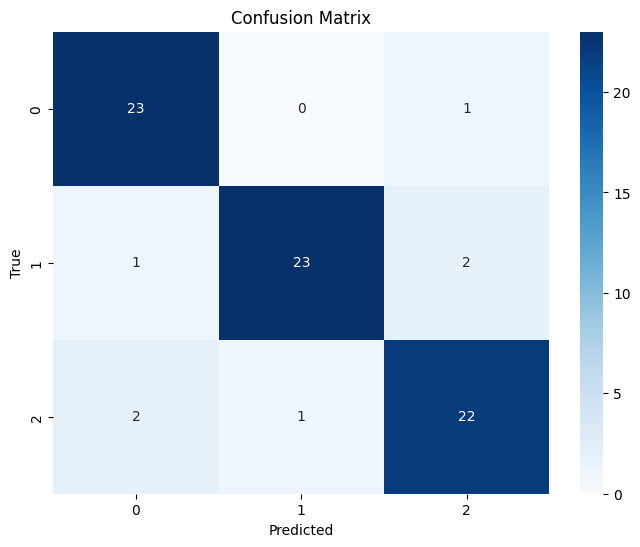

In [10]:
# Plot confusion matrix using seaborn
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.savefig("confusion_matrix_DE.png", dpi=dpi)
plt.show()

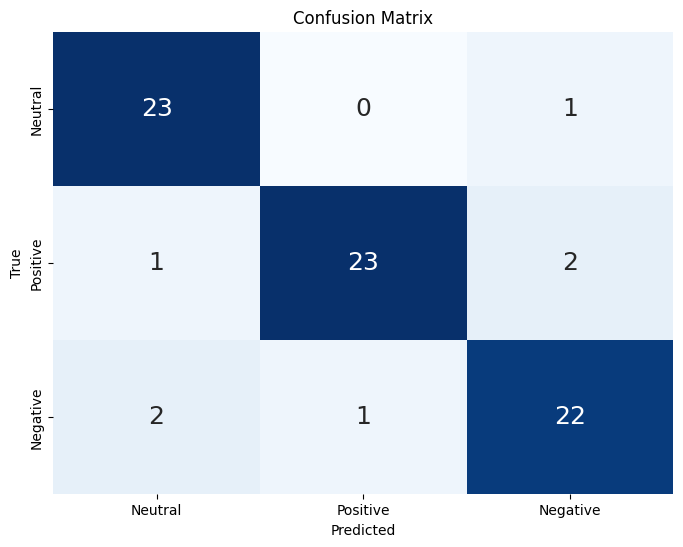

In [11]:
# Create a confusion matrix with labels
cm = confusion_matrix(y_true, y_pred_classes)

# Define class labels
class_labels = ['Neutral', 'Positive', 'Negative']

# Plot confusion matrix using seaborn without color bar and with font size 18
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False, annot_kws={"size": 18})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("confusion_matrix_try2_1.png", dpi=dpi)
plt.show()



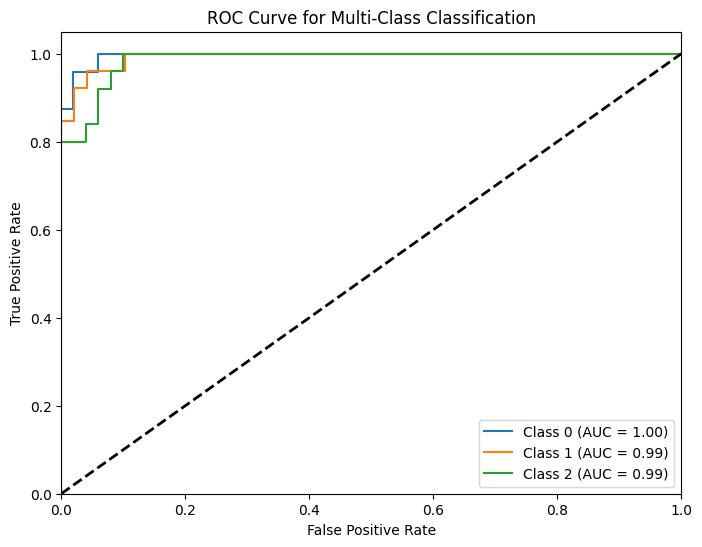

In [12]:
# Compute ROC curve and AUC for Each Class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_true, classes=[0, 1, 2])[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
#plt.savefig("ROC_DE.png", dpi=dpi)
plt.show()

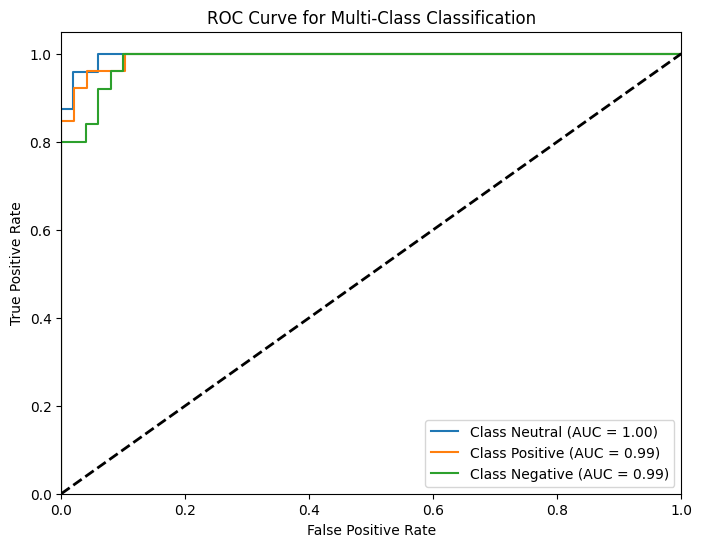

In [13]:
# Map original labels to desired labels for true labels
y_true_labels_bin = label_binarize(y_true_labels, classes=['Neutral', 'Positive', 'Negative'])

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(label_mapping.values()):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.savefig("ROC_try2_1.png", dpi=dpi)
plt.show()


In [14]:
# Save the model
model.save("model_try2_1.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
